In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 25
scale_factor = Decimal('1e15')

# Load submissions
saspav_df = pd.read_csv('/home/code/exploration/datasets/santa-2025.csv')
jazivxt_df = pd.read_csv('/home/code/exploration/datasets/submission.csv')

print("Saspav submission shape:", saspav_df.shape)
print(saspav_df.head())
print("\nJazivxt submission shape:", jazivxt_df.shape)
print(jazivxt_df.head())

Saspav submission shape: (20100, 4)
      id                          x                         y  \
0  001_0  s-48.19608619421424577922  s58.77098461521422478882   
1  002_0    s0.15409706962135588659  s-0.03854074269479464826   
2  002_1   s-0.15409706962137284525  s-0.56145925730522405761   
3  003_0    s1.12365581614030096702   s0.78110181599256300888   
4  003_1    s1.23405569584216001644   s1.27599950066375900093   

                         deg  
0   s45.00000000000000000000  
1  s203.62937773065684154972  
2   s23.62937773065679181173  
3  s111.12513229289299943048  
4   s66.37062226934300213088  

Jazivxt submission shape: (20100, 4)
      id                     x                      y                  deg
0  001_0                  s0.0   s-0.3000000000000007  s44.999999999999744
1  002_0   s0.1540970696213643  s-0.03854074269478543  s203.62937773065684
2  002_1  s-0.1540970696213643   s-0.5614592573052146  s23.629377730656792
3  003_0   s0.1857706481046834   s-0.547448842335

In [2]:
# Calculate scores for both submissions
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def calculate_score(df):
    df = df.copy()
    df['x'] = df['x'].astype(str).str.strip().str.lstrip('s')
    df['y'] = df['y'].astype(str).str.strip().str.lstrip('s')
    df['deg'] = df['deg'].astype(str).str.strip().str.lstrip('s')
    df[['group_id', 'item_id']] = df['id'].str.split('_', n=2, expand=True)
    
    total_score = Decimal('0')
    side_lengths = {}
    
    for group_id, group_data in df.groupby('group_id'):
        tree_list = [
            ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg'])
            for _, row in group_data.iterrows()
        ]
        all_polygons = [t.polygon for t in tree_list]
        bounds = unary_union(all_polygons).bounds
        side_length = Decimal(max(bounds[2] - bounds[0], bounds[3] - bounds[1])) / scale_factor
        n = int(group_id)
        side_lengths[n] = float(side_length)
        total_score += side_length ** 2 / Decimal(str(n))
    
    return float(total_score), side_lengths

print("Calculating saspav score...")
saspav_score, saspav_sides = calculate_score(saspav_df)
print(f"Saspav score: {saspav_score:.6f}")

print("\\nCalculating jazivxt score...")
jazivxt_score, jazivxt_sides = calculate_score(jazivxt_df)
print(f"Jazivxt score: {jazivxt_score:.6f}")

Calculating saspav score...


Saspav score: 70.658891
\nCalculating jazivxt score...


Jazivxt score: 70.647327


Top 10 N values with biggest score contribution (jazivxt):
  N=1: side=0.813173, contrib=0.661250
  N=2: side=0.949504, contrib=0.450779
  N=3: side=1.142031, contrib=0.434745
  N=5: side=1.443692, contrib=0.416850
  N=4: side=1.290806, contrib=0.416545
  N=7: side=1.673104, contrib=0.399897
  N=6: side=1.548438, contrib=0.399610
  N=9: side=1.867280, contrib=0.387415
  N=8: side=1.755921, contrib=0.385407
  N=15: side=2.384962, contrib=0.379203

Total score: 70.647327


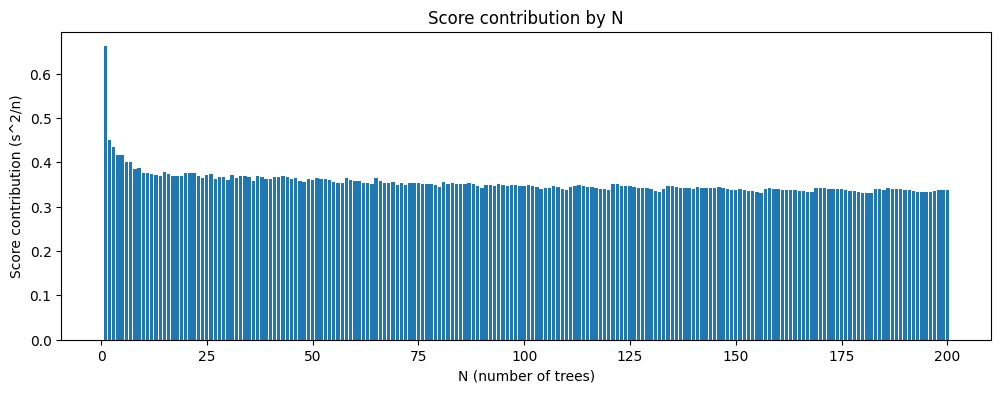

In [3]:
# Compare per-N scores to find where improvements are needed
import matplotlib.pyplot as plt

# Calculate per-N contribution to score
saspav_contrib = {n: (saspav_sides[n]**2)/n for n in saspav_sides}
jazivxt_contrib = {n: (jazivxt_sides[n]**2)/n for n in jazivxt_sides}

# Find where jazivxt is better vs saspav
diff = {n: saspav_contrib[n] - jazivxt_contrib[n] for n in saspav_contrib}

# Top 10 N values with biggest contribution to score
sorted_contrib = sorted(jazivxt_contrib.items(), key=lambda x: x[1], reverse=True)
print("Top 10 N values with biggest score contribution (jazivxt):")
for n, contrib in sorted_contrib[:10]:
    print(f"  N={n}: side={jazivxt_sides[n]:.6f}, contrib={contrib:.6f}")

print(f"\nTotal score: {sum(jazivxt_contrib.values()):.6f}")

# Plot contribution by N
ns = sorted(jazivxt_contrib.keys())
contribs = [jazivxt_contrib[n] for n in ns]
plt.figure(figsize=(12, 4))
plt.bar(ns, contribs)
plt.xlabel('N (number of trees)')
plt.ylabel('Score contribution (s^2/n)')
plt.title('Score contribution by N')
plt.savefig('score_by_n.png', dpi=100)
plt.show()

In [4]:
# Check the tree shape dimensions
print("Tree shape dimensions:")
print("  Trunk width: 0.15")
print("  Trunk height: 0.2")
print("  Base width: 0.7")
print("  Mid width: 0.4")
print("  Top width: 0.25")
print("  Tip y: 0.8")
print("  Total height: 0.8 + 0.2 = 1.0")
print("  Max width: 0.7")

# For N=1, the optimal bounding box should be the tree itself
# Rotated 45 degrees, the diagonal would be sqrt(0.7^2 + 1^2) = 1.22
# But the actual tree shape is more complex

# Check what the theoretical minimum might be
print(f"\nN=1 current side: {jazivxt_sides[1]:.6f}")
print(f"N=1 contribution: {jazivxt_contrib[1]:.6f}")

# For a single tree, the minimum bounding box depends on rotation
# Let's see what angles are being used
print("\nN=1 tree configuration:")
n1_data = jazivxt_df[jazivxt_df['id'] == '001_0']
print(n1_data)

Tree shape dimensions:
  Trunk width: 0.15
  Trunk height: 0.2
  Base width: 0.7
  Mid width: 0.4
  Top width: 0.25
  Tip y: 0.8
  Total height: 0.8 + 0.2 = 1.0
  Max width: 0.7

N=1 current side: 0.813173
N=1 contribution: 0.661250

N=1 tree configuration:
      id     x                     y                  deg
0  001_0  s0.0  s-0.3000000000000007  s44.999999999999744


In [5]:
# Check the best public submission
best_df = pd.read_csv('/home/code/exploration/datasets/submission_best.csv')
print("Best public submission shape:", best_df.shape)
print(best_df.head())

print("\\nCalculating best public score...")
best_score, best_sides = calculate_score(best_df)
print(f"Best public score: {best_score:.6f}")

Best public submission shape: (20100, 4)
      id                     x                    y                   deg
0  001_0  s-48.462025735646897  s59.036924156646883   s45.000000000000000
1  002_0    s0.354635418797758   s0.795710882346675  s203.629377730552051
2  002_1    s0.046441279555199   s0.272792367735944   s23.629377730552051
3  003_0    s0.647087199308396   s1.202535626558404  s155.134051937100821
4  003_1    s1.239428254921482   s1.298076560608782   s66.370622269343002
\nCalculating best public score...


Best public score: 70.926150


In [6]:
# Analyze per-N scores to find where improvements are most needed
# Compare jazivxt vs theoretical lower bounds

# For a single tree at 45 degrees, the bounding box should be approximately:
# The tree is 1.0 tall and 0.7 wide
# At 45 degrees, the diagonal is sqrt(1^2 + 0.7^2) = 1.22
# But the actual shape is more complex

# Let's see the per-N side lengths
print("Per-N side lengths (jazivxt):")
for n in range(1, 21):
    print(f"  N={n}: side={jazivxt_sides[n]:.6f}, contrib={jazivxt_contrib[n]:.6f}")

print(f"\nSum of contributions for N=1-20: {sum(jazivxt_contrib[n] for n in range(1, 21)):.6f}")
print(f"Sum of contributions for N=21-200: {sum(jazivxt_contrib[n] for n in range(21, 201)):.6f}")
print(f"Total: {sum(jazivxt_contrib.values()):.6f}")

Per-N side lengths (jazivxt):
  N=1: side=0.813173, contrib=0.661250
  N=2: side=0.949504, contrib=0.450779
  N=3: side=1.142031, contrib=0.434745
  N=4: side=1.290806, contrib=0.416545
  N=5: side=1.443692, contrib=0.416850
  N=6: side=1.548438, contrib=0.399610
  N=7: side=1.673104, contrib=0.399897
  N=8: side=1.755921, contrib=0.385407
  N=9: side=1.867280, contrib=0.387415
  N=10: side=1.940696, contrib=0.376630
  N=11: side=2.030803, contrib=0.374924
  N=12: side=2.114873, contrib=0.372724
  N=13: side=2.199960, contrib=0.372294
  N=14: side=2.274555, contrib=0.369543
  N=15: side=2.384962, contrib=0.379203
  N=16: side=2.446640, contrib=0.374128
  N=17: side=2.508124, contrib=0.370040
  N=18: side=2.576409, contrib=0.368771
  N=19: side=2.646449, contrib=0.368615
  N=20: side=2.742469, contrib=0.376057

Sum of contributions for N=1-20: 8.055427
Sum of contributions for N=21-200: 62.591900
Total: 70.647327


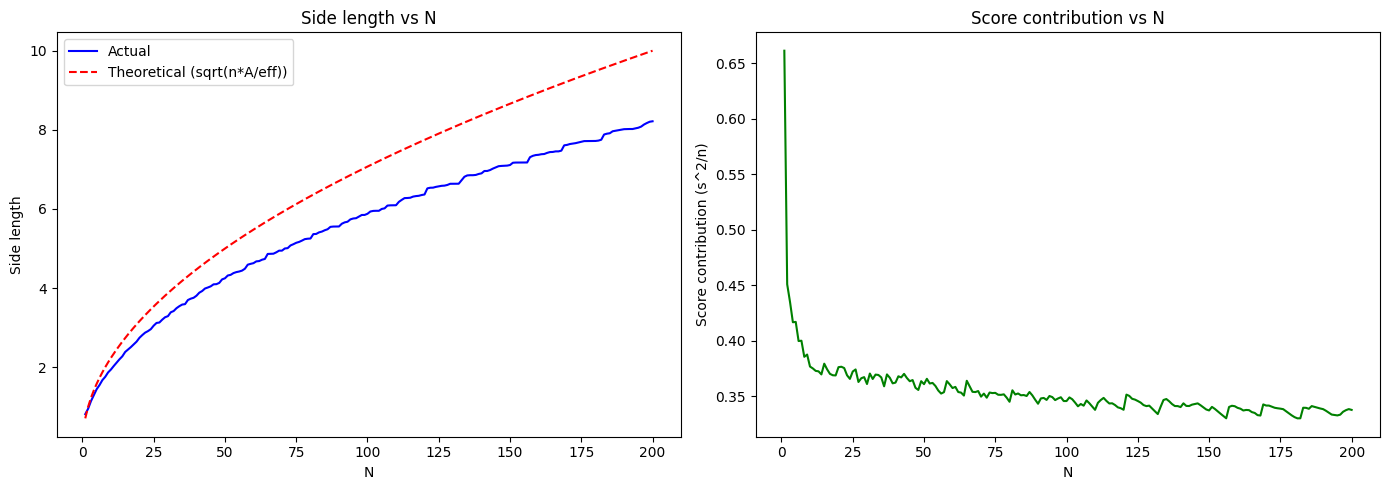

N values with worst ratio (actual/theoretical):
  N=1: ratio=1.150, side=0.8132, theoretical=0.7071
  N=2: ratio=0.950, side=0.9495, theoretical=1.0000
  N=3: ratio=0.932, side=1.1420, theoretical=1.2247
  N=5: ratio=0.913, side=1.4437, theoretical=1.5811
  N=4: ratio=0.913, side=1.2908, theoretical=1.4142
  N=7: ratio=0.894, side=1.6731, theoretical=1.8708
  N=6: ratio=0.894, side=1.5484, theoretical=1.7321
  N=9: ratio=0.880, side=1.8673, theoretical=2.1213
  N=8: ratio=0.878, side=1.7559, theoretical=2.0000
  N=15: ratio=0.871, side=2.3850, theoretical=2.7386


In [7]:
# Check if there's a pattern in side length growth
# Theoretical: for dense packing, side should grow as sqrt(n * tree_area)
# Tree area is approximately 0.7 * 1.0 / 2 = 0.35 (rough triangle approximation)

import matplotlib.pyplot as plt

ns = list(range(1, 201))
sides = [jazivxt_sides[n] for n in ns]
contribs = [jazivxt_contrib[n] for n in ns]

# Theoretical lower bound: side = sqrt(n * tree_area / packing_efficiency)
# Assuming tree area ~0.35 and packing efficiency ~0.7
tree_area = 0.35
packing_eff = 0.7
theoretical_sides = [np.sqrt(n * tree_area / packing_eff) for n in ns]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(ns, sides, 'b-', label='Actual')
axes[0].plot(ns, theoretical_sides, 'r--', label='Theoretical (sqrt(n*A/eff))')
axes[0].set_xlabel('N')
axes[0].set_ylabel('Side length')
axes[0].set_title('Side length vs N')
axes[0].legend()

axes[1].plot(ns, contribs, 'g-')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Score contribution (s^2/n)')
axes[1].set_title('Score contribution vs N')

plt.tight_layout()
plt.savefig('analysis.png', dpi=100)
plt.show()

# Find N values where actual is much worse than theoretical
ratios = [sides[i] / theoretical_sides[i] for i in range(len(ns))]
worst_ratios = sorted(enumerate(ratios), key=lambda x: x[1], reverse=True)[:10]
print("N values with worst ratio (actual/theoretical):")
for idx, ratio in worst_ratios:
    n = ns[idx]
    print(f"  N={n}: ratio={ratio:.3f}, side={sides[idx]:.4f}, theoretical={theoretical_sides[idx]:.4f}")